In [1]:
import tensorflow as tf
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow_addons.optimizers import AdamW, Yogi  # You need TensorFlow Addons for AdamW and Yogi
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
from sklearn.preprocessing import StandardScaler
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Dropout

C:\Users\werka\miniconda3\envs\py310\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\werka\miniconda3\envs\py310\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If 

In [2]:
class DataPreprocessor:
    def __init__(self, file_path):
        self.file_path = file_path

    def load_data(self):
        return pd.read_csv(self.file_path)

    def preprocess_data(self):
        data = self.load_data()
        target_name = 'diabete'
        data_target = data[target_name]
        data = data.drop([target_name], axis=1)
        
        # Splitting the data into train, test, and validation sets
        X_train, X_test, y_train, y_test = train_test_split(data, data_target, test_size=0.2, random_state=0)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=0)  # 0.25 x 0.8 = 0.2
        
        # Feature scaling
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        X_val = scaler.transform(X_val)
        
        # return X_train, X_val, X_test, y_train, y_val, y_test , data , data_target
        return X_train, X_val, X_test, y_train, y_val, y_test

In [21]:
class NeuralNetworkModel:
    def __init__(self):
        self.model = None

    def build_ann(self, input_shape, optimizer='adam'):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Dense(units=16, kernel_initializer='glorot_uniform', activation='relu', input_shape=(input_shape,)))
        model.add(tf.keras.layers.Dense(units=8, kernel_initializer='glorot_uniform', activation='relu'))
        # model.add(tf.keras.layers.Dropout(rate=0.5))
        # model.add(tf.keras.layers.Dense(units=64, kernel_initializer='glorot_uniform', activation='relu'))
        # model.add(tf.keras.layers.Dropout(rate=0.5))
        model.add(tf.keras.layers.Dense(units=1, kernel_initializer='glorot_uniform', activation='sigmoid'))
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
        self.model = model

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size):
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
        return self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                              validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr])

    def evaluate(self, X_test, y_test):
        y_pred_prob = self.model.predict(X_test)
        y_pred = np.round(y_pred_prob).astype(int).flatten()
        if isinstance(y_test, pd.Series):
           y_test = y_test.values
        y_true = y_test.flatten()
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')
        return accuracy, precision, recall, f1

In [22]:
# Example usage:
data_preprocessor = DataPreprocessor("diabete.csv")
# X_train, X_val, X_test, y_train, y_val, y_test , Xc, yc = data_preprocessor.preprocess_data()
X_train, X_val, X_test, y_train, y_val, y_test = data_preprocessor.preprocess_data()

In [23]:
# # Define reduction percentages
# reduction_percentage = 0.7

# # Reduce the size of the datasets
# X_train, _, y_train, _ = train_test_split(X_train, y_train, test_size=reduction_percentage, random_state=42)
# X_val, _, y_val, _ = train_test_split(X_val, y_val, test_size=reduction_percentage, random_state=42)
# X_test, _, y_test, _ = train_test_split(X_test, y_test, test_size=reduction_percentage, random_state=42)

In [24]:
X_train.shape , X_val.shape, X_test.shape,  y_train.shape

((460, 8), (154, 8), (154, 8), (460,))

In [30]:
# List of optimizers to test for NN
optimizers = {
    'SGD': SGD(),
    'SGD_momentum': SGD(momentum=0.9),
    'Nesterov': SGD(momentum=0.9, nesterov=True),
    'RMSprop': tf.keras.optimizers.RMSprop(),
    'Adagrad': tf.keras.optimizers.Adagrad(),
    'Adadelta': tf.keras.optimizers.Adadelta(),
    'Adam': Adam(),
    'AMSGrad': Adam(amsgrad=True),
    'AdamW': AdamW(weight_decay=1e-4),
    'Yogi': Yogi(),
    'Nadam': tf.keras.optimizers.Nadam(),
    'Adamax': tf.keras.optimizers.Adamax()
}

results = {}

# neural_network_model = NeuralNetworkModel()

for name, optimizer in optimizers.items():
    print(f"Training model with {name} optimizer...")
    neural_network_model = NeuralNetworkModel()
    neural_network_model.build_ann(X_train.shape[1], optimizer=optimizer)
    start_time = time.time()
    history = neural_network_model.train(X_train, y_train, X_val, y_val, epochs=50, batch_size=32)
    end_time = time.time()
    test_accuracy, precision, recall, f1 = neural_network_model.evaluate(X_test, y_test)
    training_time = end_time - start_time
    convergence_speed = len(history.history['loss'])
    results[name] = {
        'test_accuracy': test_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'convergence_speed': convergence_speed,
        'training_time': training_time,
        'history': history
    }

Training model with SGD optimizer...
Epoch 1/50
15/15 [==============================] - 1s 19ms/step - loss: 0.6676 - accuracy: 0.6152 - val_loss: 0.6331 - val_accuracy: 0.6818 - lr: 0.0100
Epoch 2/50
15/15 [==============================] - 0s 11ms/step - loss: 0.6496 - accuracy: 0.6391 - val_loss: 0.6189 - val_accuracy: 0.6818 - lr: 0.0100
Epoch 3/50
15/15 [==============================] - 0s 10ms/step - loss: 0.6346 - accuracy: 0.6630 - val_loss: 0.6076 - val_accuracy: 0.6948 - lr: 0.0100
Epoch 4/50
15/15 [==============================] - 0s 10ms/step - loss: 0.6222 - accuracy: 0.6761 - val_loss: 0.5982 - val_accuracy: 0.7403 - lr: 0.0100
Epoch 5/50
15/15 [==============================] - 0s 9ms/step - loss: 0.6118 - accuracy: 0.6978 - val_loss: 0.5898 - val_accuracy: 0.7403 - lr: 0.0100
Epoch 6/50
15/15 [==============================] - 0s 10ms/step - loss: 0.6023 - accuracy: 0.7087 - val_loss: 0.5827 - val_accuracy: 0.7597 - lr: 0.0100
Epoch 7/50
15/15 [======================

In [32]:
# Print results
print("\nResults:")
for name, result in results.items():
    print(f"{name}: Test Accuracy - {result['test_accuracy']:.4f}, "
          f"Precision - {result['precision']:.4f}, "
          f"Recall - {result['recall']:.4f}, "
          f"F1-score - {result['f1_score']:.4f}, "
          f"Convergence Speed - {result['convergence_speed']} epochs, "
          f"Training Time - {result['training_time']:.2f} seconds")


Results:
SGD: Test Accuracy - 0.8247, Precision - 0.8199, Recall - 0.8247, F1-score - 0.8189, Convergence Speed - 50 epochs, Training Time - 8.38 seconds
SGD_momentum: Test Accuracy - 0.8247, Precision - 0.8208, Recall - 0.8247, F1-score - 0.8218, Convergence Speed - 23 epochs, Training Time - 4.16 seconds
Nesterov: Test Accuracy - 0.8117, Precision - 0.8106, Recall - 0.8117, F1-score - 0.8111, Convergence Speed - 43 epochs, Training Time - 7.07 seconds
RMSprop: Test Accuracy - 0.8312, Precision - 0.8269, Recall - 0.8312, F1-score - 0.8264, Convergence Speed - 50 epochs, Training Time - 10.01 seconds
Adagrad: Test Accuracy - 0.6688, Precision - 0.6968, Recall - 0.6688, F1-score - 0.6782, Convergence Speed - 50 epochs, Training Time - 8.13 seconds
Adadelta: Test Accuracy - 0.7143, Precision - 0.6864, Recall - 0.7143, F1-score - 0.6751, Convergence Speed - 49 epochs, Training Time - 8.56 seconds
Adam: Test Accuracy - 0.8052, Precision - 0.8013, Recall - 0.8052, F1-score - 0.8027, Conver

In [33]:
# Data extraction for the summary
data_info = {
    'Data Name': ["Diabete"] * len(optimizers),
    'Data Size': [X_train.shape[0]] * len(optimizers),
    'Number of Features': [X_train.shape[1]] * len(optimizers),
    'Target Feature Type': [y_train.dtype] * len(optimizers),
    'Neural Network Architecture': ["FNN"] * len(optimizers),
    'Optimization Method': list(optimizers.keys())
}

# Extract results for each optimization method
results_info = {
    'Optimization Method': [],
    'Test Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-score': [],
    'Convergence Speed': [],
    'Training Time': [],
    'Training Loss': [],
    'Validation Loss': []
}

# Add the evaluation results for each optimizer
for optimizer, result in results.items():
    results_info['Optimization Method'].append(optimizer)
    results_info['Test Accuracy'].append(result['test_accuracy'])
    results_info['Precision'].append(result['precision'])
    results_info['Recall'].append(result['recall'])
    results_info['F1-score'].append(result['f1_score'])
    results_info['Convergence Speed'].append(result['convergence_speed'])
    results_info['Training Time'].append(result['training_time'])
    results_info['Training Loss'].append(result['history'].history['loss'][0])
    results_info['Validation Loss'].append(result['history'].history['val_loss'][0])

# Create DataFrames and merge them for final results
data_df = pd.DataFrame(data_info)
results_df = pd.DataFrame(results_info)
final_df = pd.merge(data_df, results_df, on='Optimization Method')

# Show the final merged data
final_df.head(12)

,Data Name,Data Size,Number of Features,Target Feature Type,Neural Network Architecture,Optimization Method,Test Accuracy,Precision,Recall,F1-score,Convergence Speed,Training Time,Training Loss,Validation Loss
0,Diabete,460,8,int64,FNN,SGD,0.824675,0.819902,0.824675,0.818931,50,8.383115,0.667620,0.633141
1,Diabete,460,8,int64,FNN,SGD_momentum,0.824675,0.820810,0.824675,0.821752,23,4.159541,0.677457,0.598205
2,Diabete,460,8,int64,FNN,Nesterov,0.811688,0.810614,0.811688,0.811114,43,7.065976,0.754315,0.682612
3,Diabete,460,8,int64,FNN,RMSprop,0.831169,0.826860,0.831169,0.826358,50,10.006810,0.699416,0.693441
4,Diabete,460,8,int64,FNN,Adagrad,0.668831,0.696790,0.668831,0.678239,50,8.128724,0.741122,0.732286
5,Diabete,460,8,int64,FNN,Adadelta,0.714286,0.686359,0.714286,0.675140,49,8.563253,0.642426,0.663228
6,Diabete,460,8,int64,FNN,Adam,0.805195,0.801320,0.805195,0.802653,38,6.648813,0.658106,0.663399
7,Diabete,460,8,int64,FNN,AMSGrad,0.811688,0.806365,0.811688,0.807095,50,10.008934,0.726442,0.724872
8,Diabete,460,8,int64,FNN,AdamW,0.785714,0.787034,0.785714,0.786339,50,9.581783,0.730021,0.723202
9,Diabete,460,8,int64,FNN,Yogi,0.798701,0.793870,0.798701,0.795345,29,6.522136,0.625382,0.570904


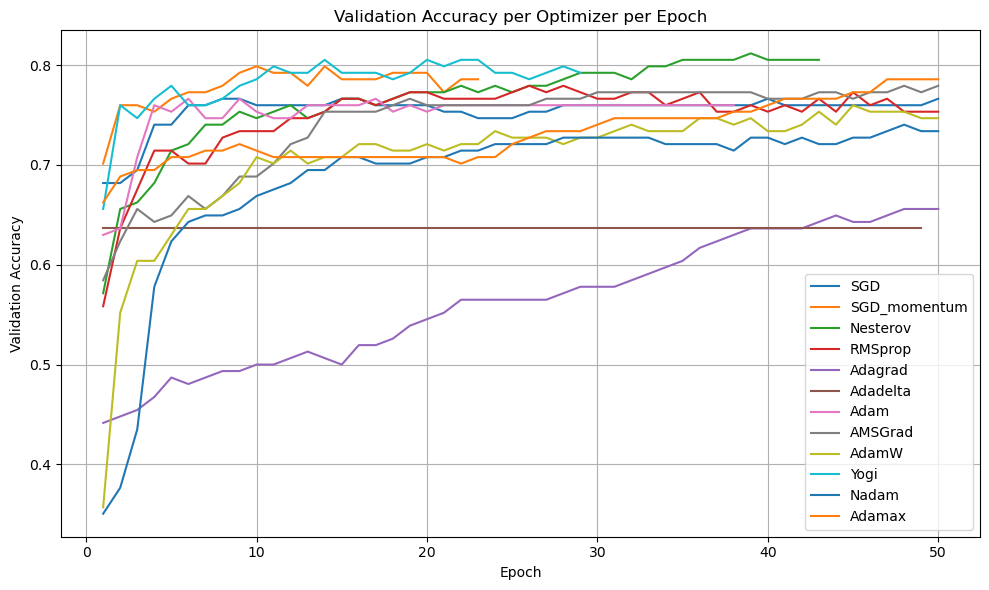

In [35]:
# Import necessary libraries
import matplotlib.pyplot as plt

# Plot Test Accuracy per Optimizer per Epoch
plt.figure(figsize=(10, 6))

# Loop through results to access each optimizer's training history
for optimizer_name, result in results.items():
    # Retrieve the validation accuracy history for this optimizer
    if 'val_accuracy' in result['history'].history:
        val_acc_history = result['history'].history['val_accuracy']
    else:
        # Sometimes the key might be 'val_acc', depending on TensorFlow version
        val_acc_history = result['history'].history.get('val_acc', [])

    # Plot the validation accuracy history
    plt.plot(range(1, len(val_acc_history) + 1), val_acc_history, label=optimizer_name)

plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy per Optimizer per Epoch')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


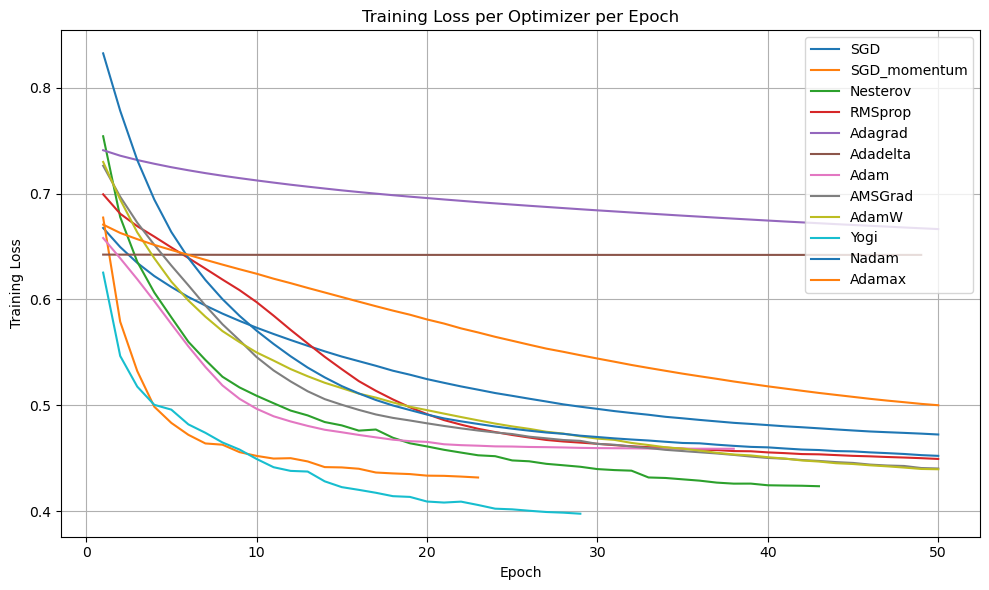

In [36]:
# Import necessary libraries
import matplotlib.pyplot as plt

# Plot Training Loss per Optimizer per Epoch
plt.figure(figsize=(10, 6))

# Loop through results to access each optimizer's training history
for optimizer_name, result in results.items():
    # Retrieve the training loss history for this optimizer
    if 'loss' in result['history'].history:
        loss_history = result['history'].history['loss']
    else:
        # In case the loss key isn't found (unexpected behavior), use a default empty list
        loss_history = []

    # Plot the training loss history
    plt.plot(range(1, len(loss_history) + 1), loss_history, label=optimizer_name)

# Set plot labels and titles
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss per Optimizer per Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [37]:
final_df.to_csv('Diabetic prediction_nn_r(3).csv', index=False)

#################################### Before Presentation #################################################

In [5]:
!pip install pandas-profiling
!pip install --upgrade pydantic
!pip install pydantic==1.8.2

  Using cached pydantic-2.7.0-py3-none-any.whl.metadata (103 kB)
Using cached pydantic-2.7.0-py3-none-any.whl (407 kB)
  Attempting uninstall: pydantic
    Found existing installation: pydantic 1.8.2
    Uninstalling pydantic-1.8.2:
      Successfully uninstalled pydantic-1.8.2


  Using cached pydantic-1.8.2-py3-none-any.whl.metadata (103 kB)
Using cached pydantic-1.8.2-py3-none-any.whl (126 kB)
  Attempting uninstall: pydantic
    Found existing installation: pydantic 2.7.0
    Uninstalling pydantic-2.7.0:
      Successfully uninstalled pydantic-2.7.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pydantic-settings 2.2.1 requires pydantic>=2.3.0, but you have pydantic 1.8.2 which is incompatible.
ydata-profiling 4.7.0 requires pydantic>=2, but you have pydantic 1.8.2 which is incompatible.


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import time
import tensorflow as tf
# preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import pandas_profiling as pp

# NN models
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping, ModelCheckpoint

# model tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [9]:
class DataPreprocessor:
    def __init__(self, file_path):
        self.file_path = file_path

    def load_data(self):
        return pd.read_csv(self.file_path)

    def preprocess_data(self):
        data = self.load_data()
        target_name = 'diabete'
        data_target = data[target_name]
        data = data.drop([target_name], axis=1)
        X_train, X_test, y_train, y_test = train_test_split(data, data_target, test_size=0.2, random_state=0)
        return X_train, X_test, y_train, y_test

In [13]:
class NeuralNetworkModel:
    def __init__(self):
        self.model = None

    def build_ann(self, input_shape, optimizer='adam'):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Dense(units=32, kernel_initializer='glorot_uniform', activation='relu', input_shape=(input_shape,)))
        model.add(tf.keras.layers.Dense(units=64, kernel_initializer='glorot_uniform', activation='relu'))
        model.add(tf.keras.layers.Dropout(rate=0.5))
        model.add(tf.keras.layers.Dense(units=64, kernel_initializer='glorot_uniform', activation='relu'))
        model.add(tf.keras.layers.Dropout(rate=0.5))
        model.add(tf.keras.layers.Dense(units=1, kernel_initializer='glorot_uniform', activation='sigmoid'))
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
        self.model = model

    def train(self, X_train, y_train, X_test, y_test, epochs=100, batch_size=16):
        history = self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))
        return history

    def evaluate(self, X_test, y_test):
        return self.model.evaluate(X_test, y_test)

In [11]:
# Example usage:
data_preprocessor = DataPreprocessor("diabete.csv")
X_train, X_test, y_train, y_test = data_preprocessor.preprocess_data()

Training model with SGD optimizer...
Epoch 1/5
20/20 [==============================] - 2s 15ms/step - loss: 2.9436 - accuracy: 0.5277 - val_loss: 0.6914 - val_accuracy: 0.5260
Epoch 2/5
20/20 [==============================] - 0s 6ms/step - loss: 1.0055 - accuracy: 0.5489 - val_loss: 0.6933 - val_accuracy: 0.6364
Epoch 3/5
20/20 [==============================] - 0s 6ms/step - loss: 0.8329 - accuracy: 0.5651 - val_loss: 0.6366 - val_accuracy: 0.6883
Epoch 4/5
20/20 [==============================] - 0s 6ms/step - loss: 0.7207 - accuracy: 0.6107 - val_loss: 0.6298 - val_accuracy: 0.6883
Epoch 5/5
5/5 [==============================] - 0s 3ms/step - loss: 0.6161 - accuracy: 0.7273
Training model with Adam optimizer...
Epoch 1/5
20/20 [==============================] - 1s 14ms/step - loss: 6.5309 - accuracy: 0.5342 - val_loss: 1.5774 - val_accuracy: 0.6948
Epoch 2/5
20/20 [==============================] - 0s 8ms/step - loss: 5.0725 - accuracy: 0.5293 - val_loss: 1.2736 - val_accuracy: 0

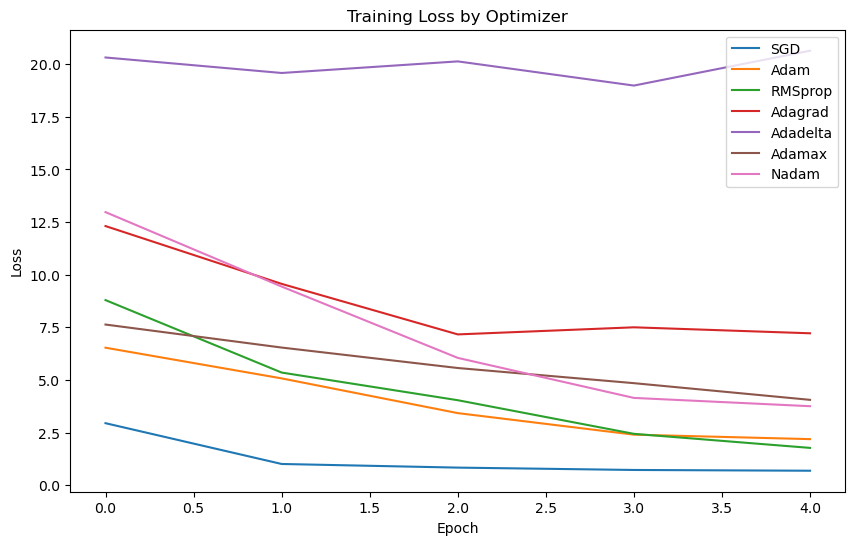

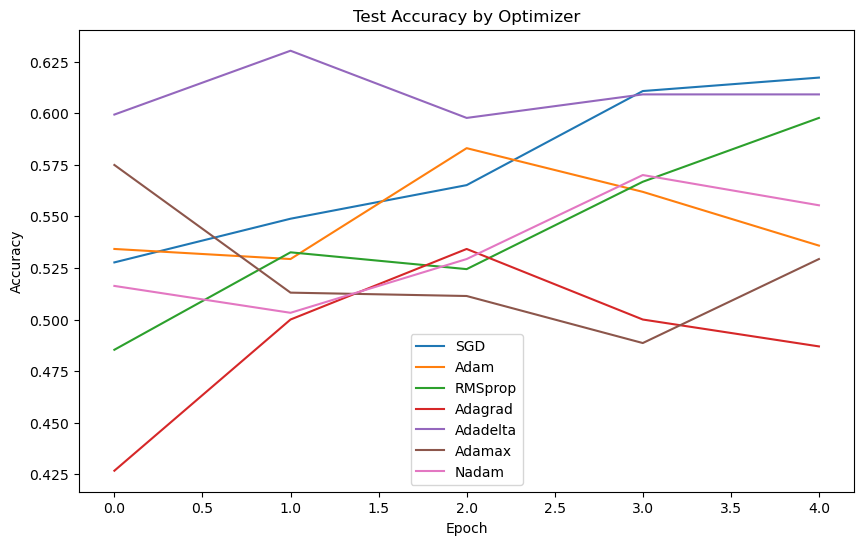

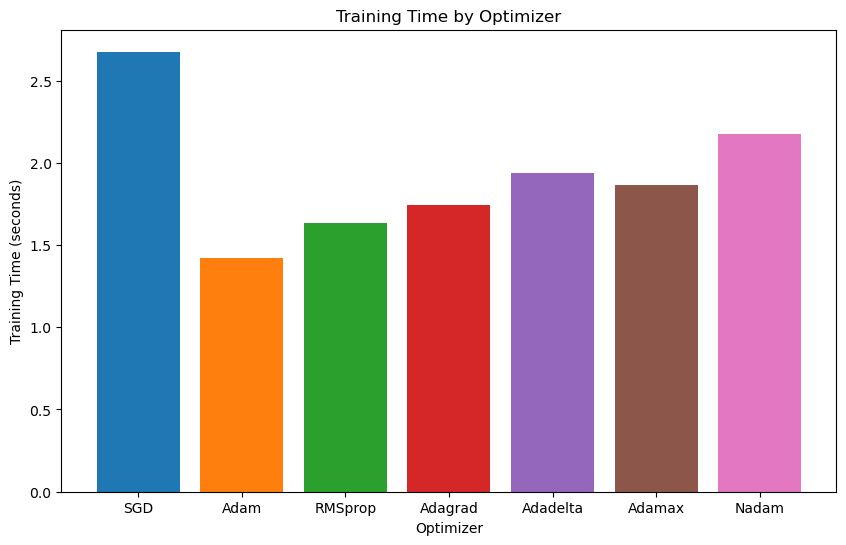

In [12]:
# List of optimizers to test for NN
optimizers = {
    'SGD': 'SGD',
    'Adam': 'adam',
    'RMSprop': 'RMSprop',
    'Adagrad': 'Adagrad',
    'Adadelta': 'Adadelta',
    'Adamax': 'Adamax',
    'Nadam': 'Nadam'
}

results = {}

neural_network_model = NeuralNetworkModel()

for name, optimizer_name in optimizers.items():
    print(f"Training model with {name} optimizer...")
    neural_network_model.build_ann(X_train.shape[1], optimizer=optimizer_name)
    start_time = time.time()
    history = neural_network_model.train(X_train, y_train, X_test, y_test, epochs=5, batch_size=32)
    end_time = time.time()
    test_loss, test_acc = neural_network_model.evaluate(X_test, y_test)
    training_time = end_time - start_time
    results[name] = {'test_accuracy': test_acc, 'convergence_speed': len(history.history['loss']), 'training_time': training_time, 'history': history}

# Print results
print("\nResults:")
for name, result in results.items():
    print(f"{name}: Test Accuracy - {result['test_accuracy']:.4f}, "
          f"Convergence Speed - {result['convergence_speed']} epochs, "
          f"Training Time - {result['training_time']:.2f} seconds")

# Plot training history
plt.figure(figsize=(10, 6))
for name, result in results.items():
    plt.plot(result['history'].history['loss'], label=name)
plt.title('Training Loss by Optimizer')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for name, result in results.items():
    plt.plot(result['history'].history['accuracy'], label=name)
plt.title('Test Accuracy by Optimizer')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for name, result in results.items():
    plt.bar(name, result['training_time'])
plt.title('Training Time by Optimizer')
plt.xlabel('Optimizer')
plt.ylabel('Training Time (seconds)')
plt.show()

In [15]:
# Step 1: Collect results and metrics
optimizer_metrics = {}  # Dictionary to store optimizer metrics

for optimizer, result in results.items():
    accuracy = result['test_accuracy']
    loss = result['history'].history['loss'][-1]
    training_time = result['training_time']
    optimizer_metrics[optimizer] = {'accuracy': accuracy, 'loss': loss, 'training_time': training_time}

# Step 2: Analyze metrics
best_optimizer = None
best_accuracy = 0
lowest_loss = float('inf')
shortest_training_time = float('inf')

for optimizer, metrics in optimizer_metrics.items():
    accuracy = metrics['accuracy']
    loss = metrics['loss']
    training_time = metrics['training_time']
    
    # Determine the best optimizer based on accuracy, loss, and training time
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        lowest_loss = loss
        shortest_training_time = training_time
        best_optimizer = optimizer
    elif accuracy == best_accuracy and loss < lowest_loss:
        lowest_loss = loss
        shortest_training_time = training_time
        best_optimizer = optimizer
    elif accuracy == best_accuracy and loss == lowest_loss and training_time < shortest_training_time:
        shortest_training_time = training_time
        best_optimizer = optimizer

# Step 3: Print or return the best performing optimizer
print(f"Best performing optimizer: {best_optimizer}")
print(f"Accuracy: {best_accuracy:.4f}")
print(f"Loss: {lowest_loss:.4f}")
print(f"Shortest Training Time: {shortest_training_time:.2f} seconds")

Best performing optimizer: SGD
Accuracy: 0.7273
Loss: 0.6850
Shortest Training Time: 2.68 seconds


Comparison of Optimizers:
          accuracy       loss  training_time
SGD       0.727273   0.684954       2.675497
Adam      0.701299   2.186319       1.422780
RMSprop   0.694805   1.769871       1.632993
Adagrad   0.707792   7.215655       1.743034
Adadelta  0.694805  20.643013       1.937908
Adamax    0.688312   4.053247       1.867730
Nadam     0.649351   3.751075       2.175797


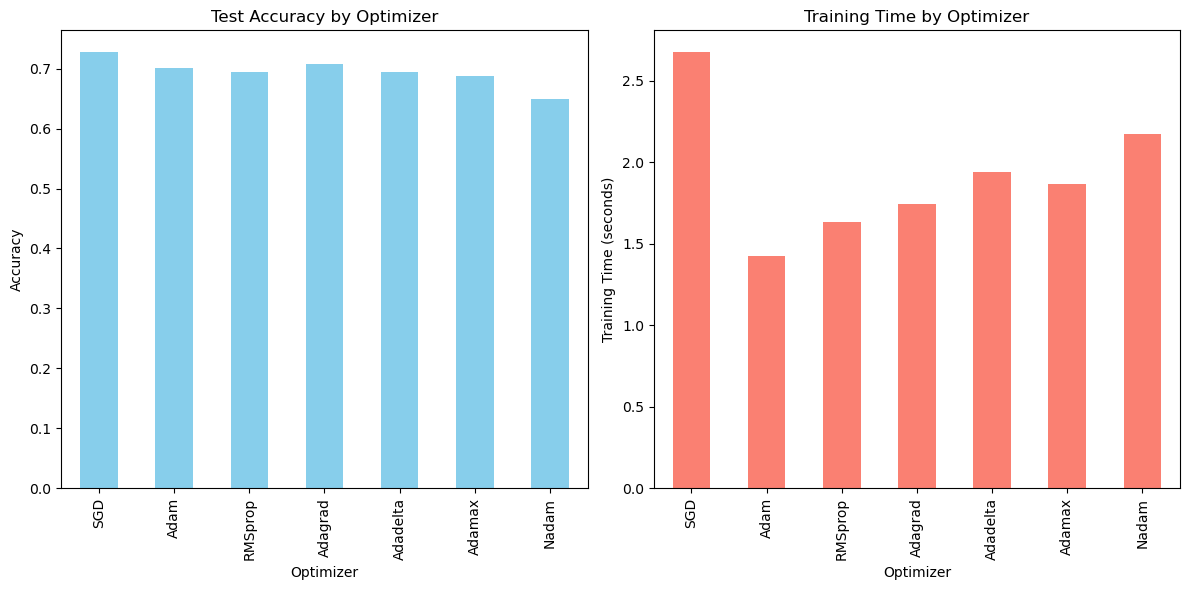

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Collect results and metrics
optimizer_metrics = {}  # Dictionary to store optimizer metrics

for optimizer, result in results.items():
    accuracy = result['test_accuracy']
    loss = result['history'].history['loss'][-1]
    training_time = result['training_time']
    optimizer_metrics[optimizer] = {'accuracy': accuracy, 'loss': loss, 'training_time': training_time}

# Step 2: Create a dataframe for comparison
df = pd.DataFrame(optimizer_metrics).T  # Transpose to have optimizers as rows

# Step 3: Plot the comparison using a table
print("Comparison of Optimizers:")
print(df)

# Step 4: Plot the comparison using a graph
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
df['accuracy'].plot(kind='bar', color='skyblue')
plt.title('Test Accuracy by Optimizer')
plt.xlabel('Optimizer')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
df['training_time'].plot(kind='bar', color='salmon')
plt.title('Training Time by Optimizer')
plt.xlabel('Optimizer')
plt.ylabel('Training Time (seconds)')

plt.tight_layout()
plt.show()


https://www.kaggle.com/code/vbmokin/diabete-prediction-20-tuned-models/notebook

In [32]:
!pip install tensorflow-addons

In [33]:
import tensorflow as tf
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow_addons.optimizers import AdamW, Yogi  # You need TensorFlow Addons for AdamW and Yogi
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import tensorflow_addons as tfa
import time

In [34]:
class DataPreprocessor:
    def __init__(self, file_path):
        self.file_path = file_path

    def load_data(self):
        return pd.read_csv(self.file_path)

    def preprocess_data(self):
        data = self.load_data()
        target_name = 'diabete'
        data_target = data[target_name]
        data = data.drop([target_name], axis=1)
        X_train, X_test, y_train, y_test = train_test_split(data, data_target, test_size=0.2, random_state=0)
        return X_train, X_test, y_train, y_test

In [35]:
class NeuralNetworkModel:
    def __init__(self):
        self.model = None

    def build_ann(self, input_shape, optimizer='adam'):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Dense(units=32, kernel_initializer='glorot_uniform', activation='relu', input_shape=(input_shape,)))
        model.add(tf.keras.layers.Dense(units=64, kernel_initializer='glorot_uniform', activation='relu'))
        model.add(tf.keras.layers.Dropout(rate=0.5))
        model.add(tf.keras.layers.Dense(units=64, kernel_initializer='glorot_uniform', activation='relu'))
        model.add(tf.keras.layers.Dropout(rate=0.5))
        model.add(tf.keras.layers.Dense(units=1, kernel_initializer='glorot_uniform', activation='sigmoid'))
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
        self.model = model

    def train(self, X_train, y_train, X_test, y_test, epochs=100, batch_size=16):
        history = self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))
        return history

    def evaluate(self, X_test, y_test):
        return self.model.evaluate(X_test, y_test)

In [36]:
# Example usage:
data_preprocessor = DataPreprocessor("diabete.csv")
X_train, X_test, y_train, y_test = data_preprocessor.preprocess_data()

Training model with SGD optimizer...
5/5 [==============================] - 0s 3ms/step - loss: 0.7007 - accuracy: 0.6883
Training model with SGD_momentum optimizer...
5/5 [==============================] - 0s 4ms/step - loss: 0.6678 - accuracy: 0.6883
Training model with Nesterov optimizer...
5/5 [==============================] - 0s 4ms/step - loss: 0.6903 - accuracy: 0.6623
Training model with RMSprop optimizer...
5/5 [==============================] - 0s 5ms/step - loss: 2.0018 - accuracy: 0.6234
Training model with Adagrad optimizer...
5/5 [==============================] - 0s 5ms/step - loss: 2.0064 - accuracy: 0.3571
Training model with Adadelta optimizer...
5/5 [==============================] - 0s 5ms/step - loss: 3.7661 - accuracy: 0.2987
Training model with Adam optimizer...
5/5 [==============================] - 0s 4ms/step - loss: 1.1689 - accuracy: 0.6039
Training model with AMSGrad optimizer...
5/5 [==============================] - 0s 4ms/step - loss: 0.8735 - accuracy:

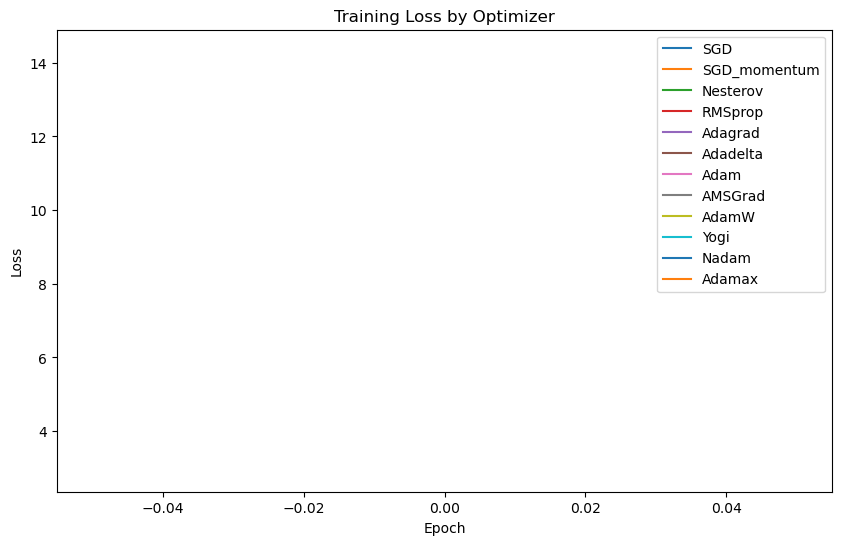

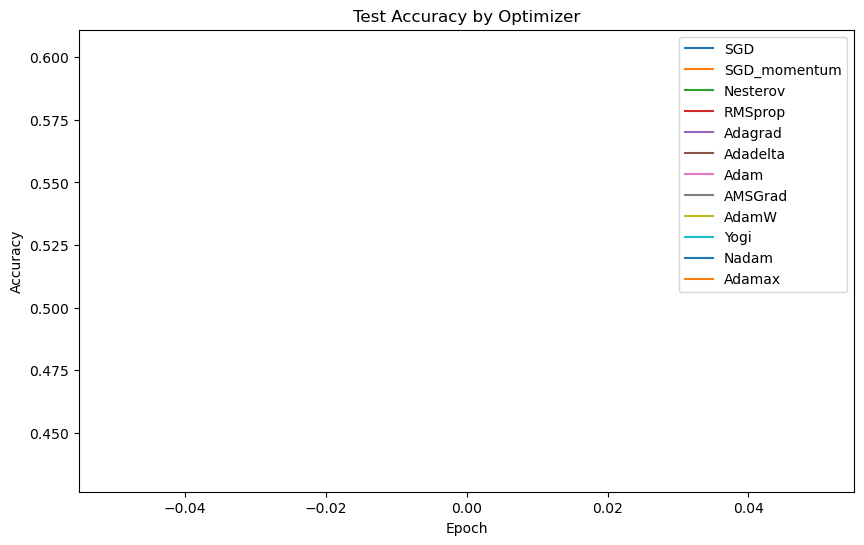

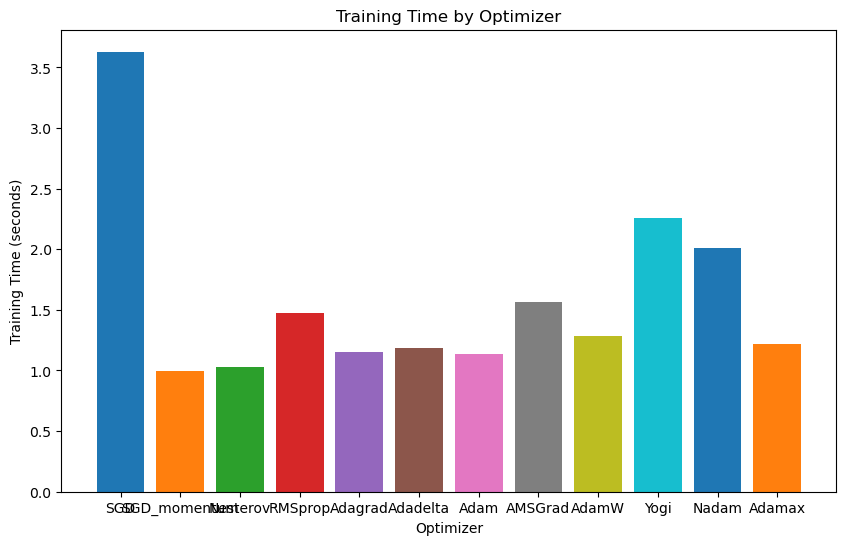

In [29]:
import matplotlib.pyplot as plt

# List of optimizers to test for NN
optimizers = {
    'SGD': tf.keras.optimizers.SGD(),
    'SGD_momentum': tf.keras.optimizers.SGD(momentum=0.9),
    'Nesterov': tf.keras.optimizers.SGD(momentum=0.9, nesterov=True),
    'RMSprop': tf.keras.optimizers.RMSprop(),
    'Adagrad': tf.keras.optimizers.Adagrad(),
    'Adadelta': tf.keras.optimizers.Adadelta(),
    'Adam': tf.keras.optimizers.Adam(),
    'AMSGrad': tf.keras.optimizers.Adam(amsgrad=True),
    'AdamW': tfa.optimizers.AdamW(weight_decay=1e-4),
    'Yogi': tfa.optimizers.Yogi(),
    'Nadam': tf.keras.optimizers.Nadam(),
    'Adamax': tf.keras.optimizers.Adamax()
}

results = {}

neural_network_model = NeuralNetworkModel()

for name, optimizer_name in optimizers.items():
    print(f"Training model with {name} optimizer...")
    neural_network_model = NeuralNetworkModel()
    neural_network_model.build_ann(X_train.shape[1], optimizer=optimizer_name)
    start_time = time.time()
    history = neural_network_model.train(X_train, y_train, X_test, y_test, epochs=1, batch_size=32)
    end_time = time.time()
    test_loss, test_acc = neural_network_model.evaluate(X_test, y_test)
    training_time = end_time - start_time
    results[name] = {'test_accuracy': test_acc, 'convergence_speed': len(history.history['loss']), 'training_time': training_time, 'history': history}

# Print results
print("\nResults:")
for name, result in results.items():
    print(f"{name}: Test Accuracy - {result['test_accuracy']:.4f}, "
          f"Convergence Speed - {result['convergence_speed']} epochs, "
          f"Training Time - {result['training_time']:.2f} seconds")

# Plot training history
plt.figure(figsize=(10, 6))
for name, result in results.items():
    plt.plot(result['history'].history['loss'], label=name)
plt.title('Training Loss by Optimizer')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for name, result in results.items():
    plt.plot(result['history'].history['accuracy'], label=name)
plt.title('Test Accuracy by Optimizer')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for name, result in results.items():
    plt.bar(name, result['training_time'])
plt.title('Training Time by Optimizer')
plt.xlabel('Optimizer')
plt.ylabel('Training Time (seconds)')
plt.show()

In [30]:
# Step 1: Collect results and metrics
optimizer_metrics = {}  # Dictionary to store optimizer metrics

for optimizer, result in results.items():
    accuracy = result['test_accuracy']
    loss = result['history'].history['loss'][-1]
    training_time = result['training_time']
    optimizer_metrics[optimizer] = {'accuracy': accuracy, 'loss': loss, 'training_time': training_time}

# Step 2: Analyze metrics
best_optimizer = None
best_accuracy = 0
lowest_loss = float('inf')
shortest_training_time = float('inf')

for optimizer, metrics in optimizer_metrics.items():
    accuracy = metrics['accuracy']
    loss = metrics['loss']
    training_time = metrics['training_time']
    
    # Determine the best optimizer based on accuracy, loss, and training time
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        lowest_loss = loss
        shortest_training_time = training_time
        best_optimizer = optimizer
    elif accuracy == best_accuracy and loss < lowest_loss:
        lowest_loss = loss
        shortest_training_time = training_time
        best_optimizer = optimizer
    elif accuracy == best_accuracy and loss == lowest_loss and training_time < shortest_training_time:
        shortest_training_time = training_time
        best_optimizer = optimizer

# Step 3: Print or return the best performing optimizer
print(f"Best performing optimizer: {best_optimizer}")
print(f"Accuracy: {best_accuracy:.4f}")
print(f"Loss: {lowest_loss:.4f}")
print(f"Shortest Training Time: {shortest_training_time:.2f} seconds")

Best performing optimizer: Adamax
Accuracy: 0.7013
Loss: 9.9467
Shortest Training Time: 1.22 seconds


Comparison of Optimizers:
              accuracy       loss  training_time
SGD           0.688312   3.330514       3.629432
SGD_momentum  0.688312   3.892674       0.992416
Nesterov      0.662338   2.925295       1.025601
RMSprop       0.623377   7.499907       1.476745
Adagrad       0.357143  13.741437       1.155597
Adadelta      0.298701  12.458871       1.184815
Adam          0.603896   8.554374       1.135726
AMSGrad       0.584416  10.080690       1.567997
AdamW         0.337662   9.991634       1.282575
Yogi          0.694805   4.469934       2.260283
Nadam         0.519481  14.328259       2.011271
Adamax        0.701299   9.946662       1.221393


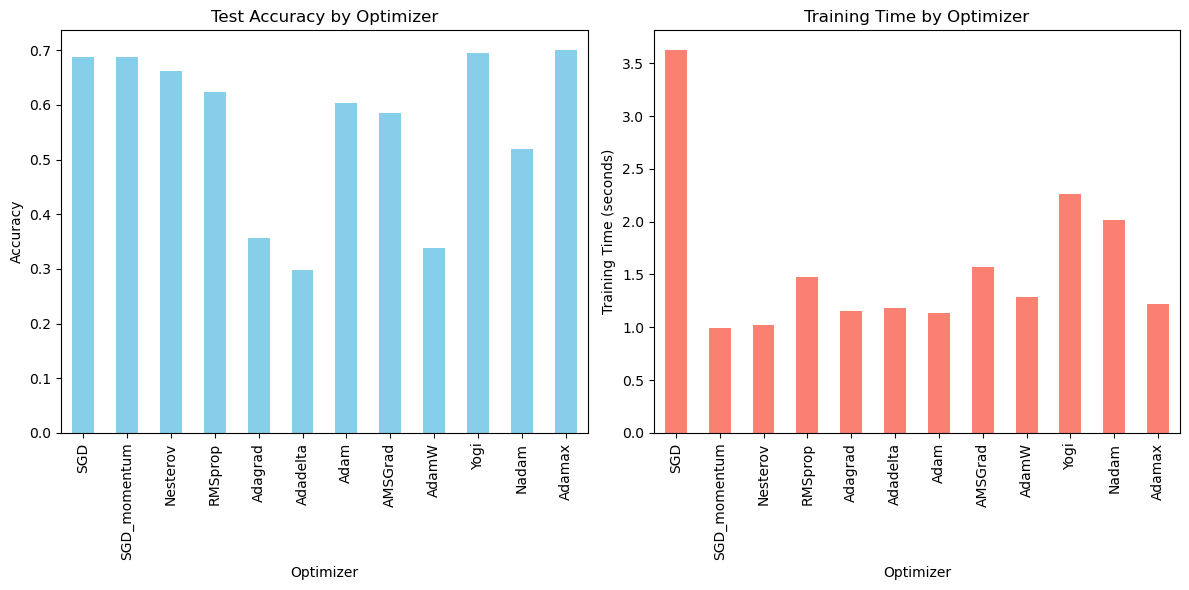

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Collect results and metrics
optimizer_metrics = {}  # Dictionary to store optimizer metrics

for optimizer, result in results.items():
    accuracy = result['test_accuracy']
    loss = result['history'].history['loss'][-1]
    training_time = result['training_time']
    optimizer_metrics[optimizer] = {'accuracy': accuracy, 'loss': loss, 'training_time': training_time}

# Step 2: Create a dataframe for comparison
df = pd.DataFrame(optimizer_metrics).T  # Transpose to have optimizers as rows

# Step 3: Plot the comparison using a table
print("Comparison of Optimizers:")
print(df)

# Step 4: Plot the comparison using a graph
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
df['accuracy'].plot(kind='bar', color='skyblue')
plt.title('Test Accuracy by Optimizer')
plt.xlabel('Optimizer')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
df['training_time'].plot(kind='bar', color='salmon')
plt.title('Training Time by Optimizer')
plt.xlabel('Optimizer')
plt.ylabel('Training Time (seconds)')

plt.tight_layout()
plt.show()


In [45]:
import tensorflow as tf
import tensorflow_addons as tfa
import time
import pandas as pd
import matplotlib.pyplot as plt

class OptimizerEvaluator:
    def __init__(self, model_builder, X_train, y_train, X_test, y_test):
        self.model_builder = model_builder  # This will build and return a new model instance
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.results = {}

        self.optimizers = {
            'SGD': tf.keras.optimizers.SGD(),
            'SGD_momentum': tf.keras.optimizers.SGD(momentum=0.9),
            'Nesterov': tf.keras.optimizers.SGD(momentum=0.9, nesterov=True),
            'RMSprop': tf.keras.optimizers.RMSprop(),
            'Adagrad': tf.keras.optimizers.Adagrad(),
            'Adadelta': tf.keras.optimizers.Adadelta(),
            'Adam': tf.keras.optimizers.Adam(),
            'AMSGrad': tf.keras.optimizers.Adam(amsgrad=True),
            'AdamW': tfa.optimizers.AdamW(weight_decay=1e-4),
            'Yogi': tfa.optimizers.Yogi(),
            'Nadam': tf.keras.optimizers.Nadam(),
            'Adamax': tf.keras.optimizers.Adamax()
        }

    def evaluate_optimizers(self):
        for name, optimizer in self.optimizers.items():
            print(f"Training model with {name} optimizer...")
            neural_network_model = NeuralNetworkModel()
            neural_network_model.build_ann(X_train.shape[1], optimizer=optimizer)
            start_time = time.time()
            history = neural_network_model.train(X_train, y_train, X_test, y_test, epochs=100, batch_size=32)
            end_time = time.time()
            test_loss, test_acc = neural_network_model.evaluate(X_test, y_test)
            training_time = end_time - start_time

            self.results[name] = {
                'test_accuracy': test_acc,
                'convergence_speed': len(history.history['loss']),
                'training_time': training_time,
                'history': history
            }

    def determine_best_optimizer(self):
        best_optimizer = None
        best_accuracy = 0
        lowest_loss = float('inf')
        shortest_training_time = float('inf')

        for optimizer, metrics in self.results.items():
            accuracy = metrics['test_accuracy']
            loss = metrics['history'].history['loss'][-1]
            training_time = metrics['training_time']

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                lowest_loss = loss
                shortest_training_time = training_time
                best_optimizer = optimizer
            elif accuracy == best_accuracy and loss < lowest_loss:
                lowest_loss = loss
                shortest_training_time = training_time
                best_optimizer = optimizer
            elif accuracy == best_accuracy and loss == lowest_loss and training_time < shortest_training_time:
                shortest_training_time = training_time
                best_optimizer = optimizer

        return {
            'best_optimizer': best_optimizer,
            'accuracy': best_accuracy,
            'loss': lowest_loss,
            'training_time': shortest_training_time
        }

   
    def display_results(self):
        # Create a dataframe for comparison
        df = pd.DataFrame.from_dict({
            optimizer: {
                'accuracy': result['test_accuracy'],
                'loss': result['history'].history['loss'][-1],
                'training_time': result['training_time']
            } for optimizer, result in self.results.items()
        }, orient='index')
    
        # Print comparison table
        print("Comparison of Optimizers:")
        print(df)
    
        # Plot the comparison using graphs
        plt.figure(figsize=(18, 6))  # Adjusted the figure size to accommodate three subplots
    
        # Plot accuracy comparison
        plt.subplot(1, 3, 1)
        df['accuracy'].plot(kind='bar', color='skyblue')
        plt.title('Test Accuracy by Optimizer')
        plt.xlabel('Optimizer')
        plt.ylabel('Accuracy')
    
        # Plot training time comparison
        plt.subplot(1, 3, 2)
        df['training_time'].plot(kind='bar', color='salmon')
        plt.title('Training Time by Optimizer')
        plt.xlabel('Optimizer')
        plt.ylabel('Training Time (seconds)')
    
        # Plot loss comparison
        plt.subplot(1, 3, 3)
        for name, result in self.results.items():
            plt.plot(result['history'].history['loss'], label=name)
        plt.title('Training Loss by Optimizer')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
    
        plt.tight_layout()  # Ensure layout doesn't overlap
        plt.show()

   

Training model with SGD optimizer...
Epoch 1/100
20/20 [==============================] - 1s 22ms/step - loss: 6.1050 - accuracy: 0.5521 - val_loss: 0.6514 - val_accuracy: 0.5974
Epoch 2/100
20/20 [==============================] - 0s 12ms/step - loss: 0.8564 - accuracy: 0.5554 - val_loss: 0.6742 - val_accuracy: 0.6299
Epoch 3/100
20/20 [==============================] - 0s 11ms/step - loss: 0.7525 - accuracy: 0.5717 - val_loss: 0.6563 - val_accuracy: 0.6883
Epoch 4/100
20/20 [==============================] - 0s 11ms/step - loss: 0.7011 - accuracy: 0.6026 - val_loss: 0.6521 - val_accuracy: 0.6753
Epoch 5/100
20/20 [==============================] - 0s 11ms/step - loss: 0.6889 - accuracy: 0.6124 - val_loss: 0.6436 - val_accuracy: 0.7208
Epoch 6/100
20/20 [==============================] - 0s 12ms/step - loss: 0.6931 - accuracy: 0.6124 - val_loss: 0.6299 - val_accuracy: 0.6948
Epoch 7/100
20/20 [==============================] - 0s 11ms/step - loss: 0.7115 - accuracy: 0.5733 - val_loss:

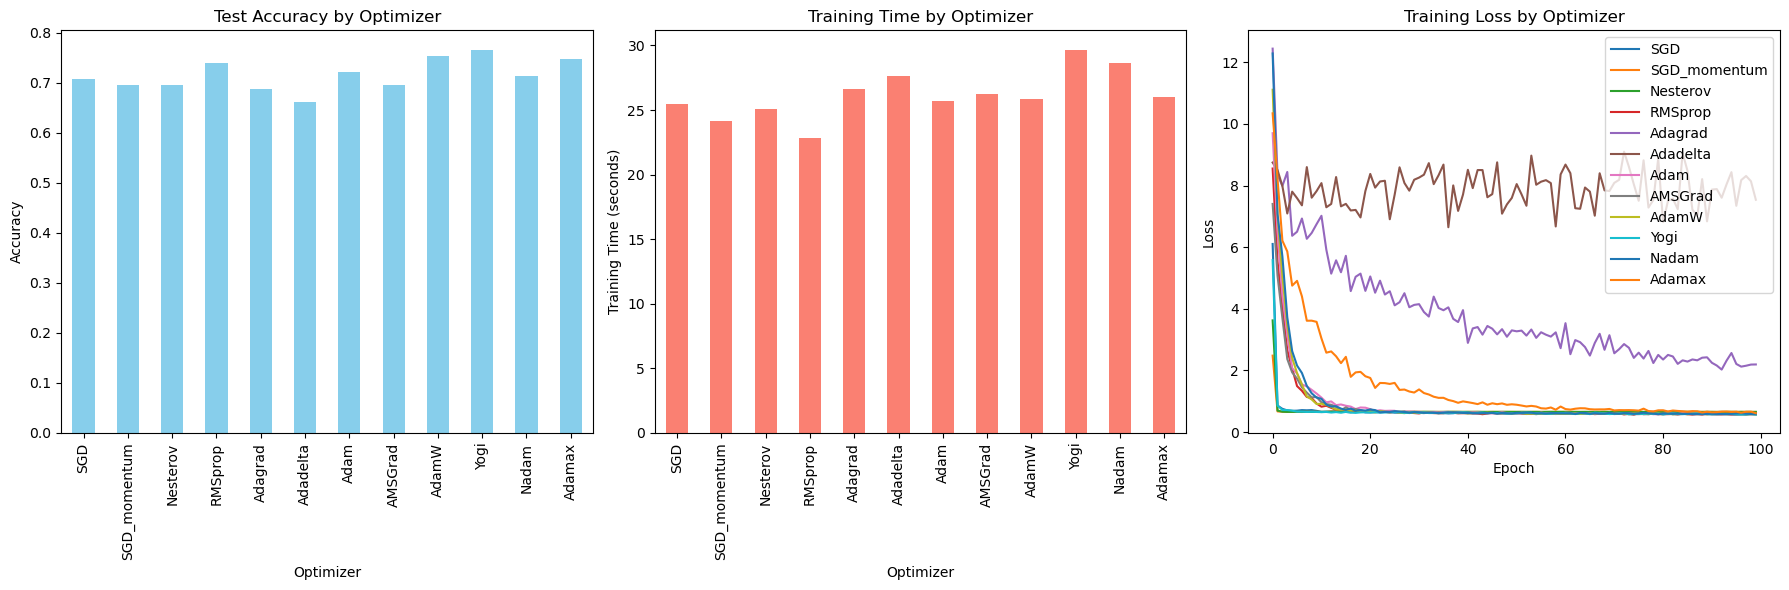

Best performing optimizer: Yogi
Accuracy: 0.7662337422370911
Loss: 0.5659579038619995
Training Time: 29.68322467803955 seconds


In [46]:
# Instantiate the model
model_builder = NeuralNetworkModel()

evaluator = OptimizerEvaluator(model_builder, X_train, y_train, X_test, y_test)
evaluator.evaluate_optimizers()  # Train models using different optimizers
best_optimizer = evaluator.determine_best_optimizer()  # Find the best optimizer
evaluator.display_results()  # Print results and plot comparisons

print("Best performing optimizer:", best_optimizer['best_optimizer'])
print("Accuracy:", best_optimizer['accuracy'])
print("Loss:", best_optimizer['loss'])
print("Training Time:", best_optimizer['training_time'], "seconds")